# Block Model with a 1D background - Comparison

### For the model, see the notebook BlockModel.ipynb

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Load data

In [3]:
def extract_lines(name):
    inp = xr.load_dataset(name, engine='h5netcdf')
    print_attributes(inp)
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out


def print_attributes(inp):
    for key in ['runtime', 'n_procs', 'max_ram',
                'n_cells', 'n_nodes', 'n_dof', 'extent',
                'min_vol', 'max_vol', 'machine',
                'version', 'date']:
        print(f"{key:10} : {inp.attrs[key]}")

In [4]:
ds = xr.load_dataset('block_model_and_survey.nc', engine='h5netcdf')
rec_x = ds.x[::2]
rec_y = ds.attrs['rec_y']

### Semi-analytical background result from `empymod`

In [5]:
epm_1d = extract_lines('results/layered_empymod.nc')

runtime    : <1 s
n_procs    : 1
max_ram    : 0 MiB
n_cells    : N/A
n_nodes    : N/A
n_dof      : N/A
extent     : N/A
min_vol    : N/A
max_vol    : N/A
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04
version    : empymod v2.0.0rc2
date       : 2020-04-01T14:04:04.343928


### `emg3d`

In [16]:
# BACKGROUND
egd_bg = extract_lines('results/layered_emg3d.nc')
print(f"\n= - = - =  :  {14*'= - '}=\n")
# 3D
egd_tg = extract_lines('results/block_emg3d.nc')

runtime    : 128 s
cputime    : 128 s
nthreads   : 1
maxram     : 349 MiB
ncells     : (256 x 64 x 96) - 1572864
nnodes     : N/A
ndof       : N/A
extent     : x = -57087.8-65201.2; y = -51967.8-51967.8; z = -35514.7-65482.0
min_cwidth : (100.0 x 200.0 x 50.0)
max_cwidth : (8113.4 x 14623.9 x 19403.1)
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04
version    : emg3d v0.9.3
date       : 2020-03-20T18:46:43.039475

= - = - =  :  = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 208 s
cputime    : 208 s
nthreads   : 1
maxram     : 349 MiB
ncells     : (256 x 64 x 96) - 1572864
nnodes     : N/A
ndof       : N/A
extent     : x = -57137.8-57137.8; y = -51967.8-51967.8; z = -35514.7-65482.0
min_cwidth : (100.0 x 200.0 x 50.0)
max_cwidth : (6934.5 x 14623.9 x 19403.1)
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04
version    : emg3d v0.9.3
date       : 2020-03-20T18:43:34.470554


### `PETGEM`

In [6]:
# BACKGROUND
ptg0 = np.load('results/PETGEM_old/y_0_E_bm_p2.npy')
# ptgp = np.load('results/PETGEM_old/y_3000_E_bm.npy')
ptgm = np.load('results/PETGEM_old/y_-3000_E_bm_p2.npy')
ptg_bg = np.vstack([ptgm[:, 0], ptg0[:, 0], ptgm[:, 0]]).T
# Take conjugate, PETGEM uses -iwt, as oposed to emg3d/custEM which have iwt.
ptg_bg = ptg_bg.conj()

# 3D
ptg0 = np.load('results/PETGEM_old/y_0_E_le_p2.npy')
ptgp = np.load('results/PETGEM_old/y_3000_E_le_p2.npy')
ptgm = np.load('results/PETGEM_old/y_-3000_E_le_p2.npy')
ptg = np.vstack([ptgm[:, 0], ptg0[:, 0], ptgp[:, 0]]).T
# Take conjugate, PETGEM uses -iwt, as oposed to emg3d/custEM which have iwt.
ptg = ptg.conj()

### `custEM`

In [7]:
# BACKGROUND
cst0 = np.load('results/custEM_old/y_0_E_le_p2.npy')
# cstp = np.load('results/custEM_old/y_3000_E_le.npy')
cstm = np.load('results/custEM_old/y_-3000_E_le_p2.npy')
cst_bg = np.vstack([cstm[:, 0], cst0[:, 0], cstm[:, 0]]).T #, cstp[:, 0]]).T

# 3D
cst0 = np.load('results/custEM_old/y_0_E_bm_p2.npy')
cstp = np.load('results/custEM_old/y_3000_E_bm_p2.npy')
cstm = np.load('results/custEM_old/y_-3000_E_bm_p2.npy')
cst = np.vstack([cstm[:, 0], cst0[:, 0], cstp[:, 0]]).T

## Compare 1D background

In [9]:
# Calculate error
egd_rerr = np.clip(100*abs((epm_1d.real-egd_bg.real)/epm_1d.real), 0.01, 100)
cst_rerr = np.clip(100*abs((epm_1d.real-cst_bg.real)/epm_1d.real), 0.01, 100)
ptg_rerr = np.clip(100*abs((epm_1d.real-ptg_bg.real)/epm_1d.real), 0.01, 100)
egd_ierr = np.clip(100*abs((epm_1d.imag-egd_bg.imag)/epm_1d.imag), 0.01, 100)
cst_ierr = np.clip(100*abs((epm_1d.imag-cst_bg.imag)/epm_1d.imag), 0.01, 100)
ptg_ierr = np.clip(100*abs((epm_1d.imag-ptg_bg.imag)/epm_1d.imag), 0.01, 100)

<IPython.core.display.Javascript object>


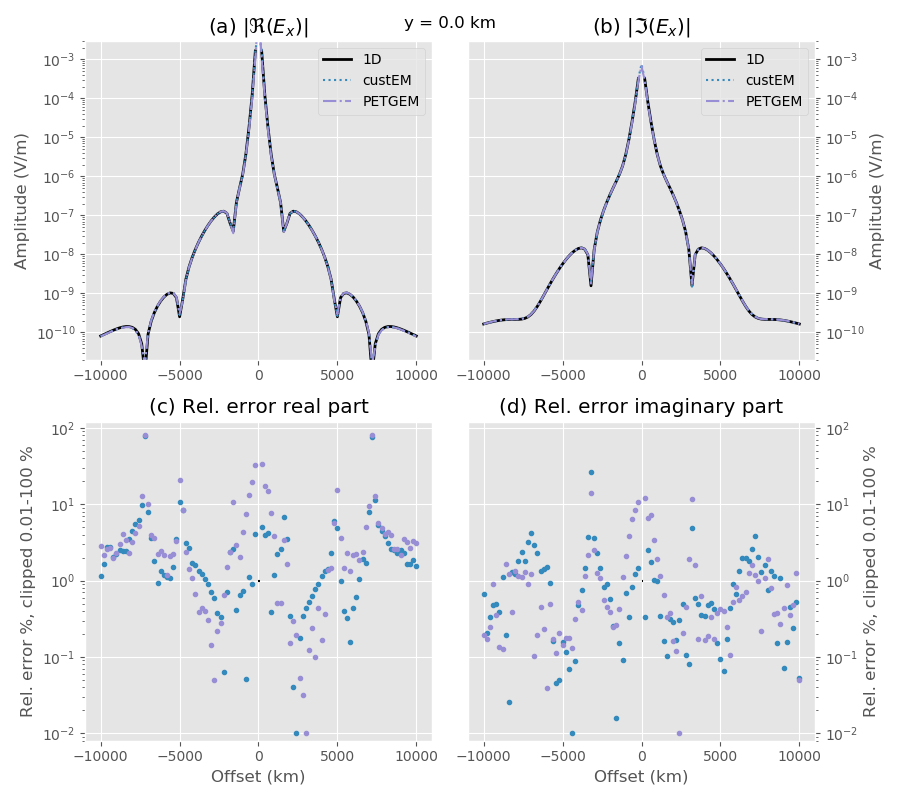

In [10]:
plt.figure(figsize=(9, 8))
plt.suptitle(f'y = {rec_y[1]/1e3} km')
# Real
ax1 = plt.subplot(221)
plt.title(r'(a) $|\Re(E_x)|$')
plt.plot(rec_x, abs(epm_1d[:, 1].real), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 1].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 1].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 1].real), f'C2-.', label=f'PETGEM')

plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(222, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

plt.plot(rec_x, abs(epm_1d[:, 1].imag), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 1].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 1].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 1].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

# Real
ax3 = plt.subplot(223)
plt.title('(c) Rel. error real part')

plt.plot(rec_x, egd_rerr[:, 1], 'C0.')
plt.plot(rec_x, cst_rerr[:, 1], 'C1.')
plt.plot(rec_x, ptg_rerr[:, 1], 'C2.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

# Imaginary
ax4 = plt.subplot(224, sharey=ax3)
plt.title('(d) Rel. error imaginary part')

plt.plot(rec_x, egd_ierr[:, 1], 'C0.')
plt.plot(rec_x, cst_ierr[:, 1], 'C1.')
plt.plot(rec_x, ptg_ierr[:, 1], 'C2.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


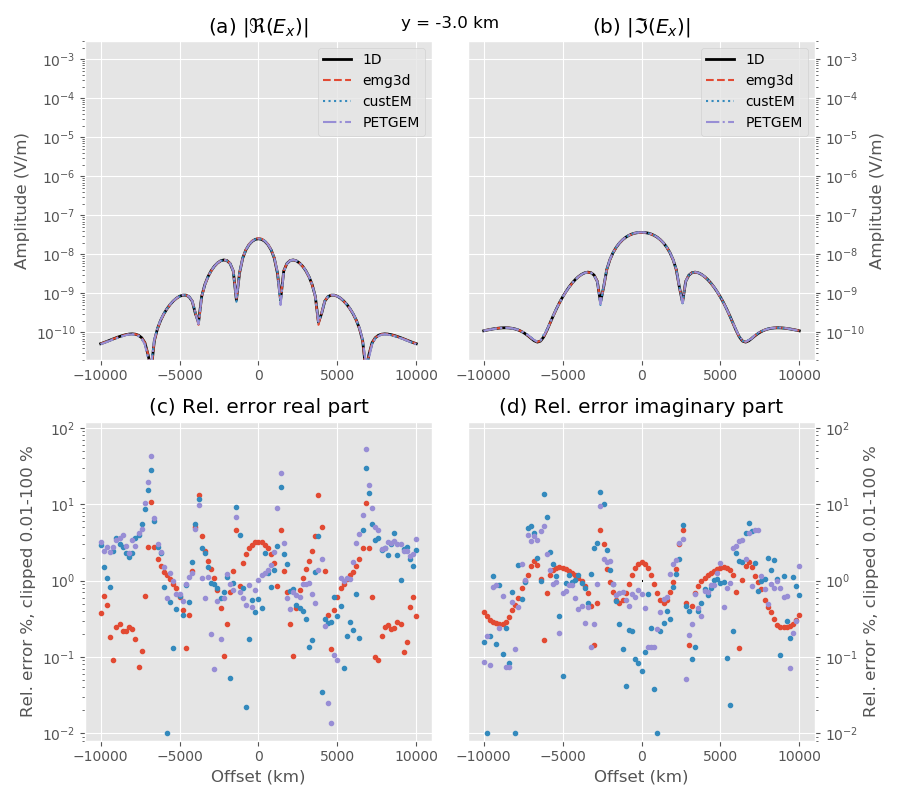

In [11]:
plt.figure(figsize=(9, 8))
plt.suptitle(f'y = {rec_y[0]/1e3} km')
# Real
ax1 = plt.subplot(221)
plt.title(r'(a) $|\Re(E_x)|$')
plt.plot(rec_x, abs(epm_1d[:, 0].real), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 0].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 0].real), f'C2-.', label=f'PETGEM')

plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(222, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

plt.plot(rec_x, abs(epm_1d[:, 0].imag), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 0].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 0].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

# Real
ax3 = plt.subplot(223)
plt.title('(c) Rel. error real part')

plt.plot(rec_x, egd_rerr[:, 0], 'C0.')
plt.plot(rec_x, cst_rerr[:, 0], 'C1.')
plt.plot(rec_x, ptg_rerr[:, 0], 'C2.')

plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

# Imaginary
ax4 = plt.subplot(224, sharey=ax3)
plt.title('(d) Rel. error imaginary part')

plt.plot(rec_x, egd_ierr[:, 0], 'C0.')
plt.plot(rec_x, cst_ierr[:, 0], 'C1.')
plt.plot(rec_x, ptg_ierr[:, 0], 'C2.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

## Compare 3D model

<IPython.core.display.Javascript object>


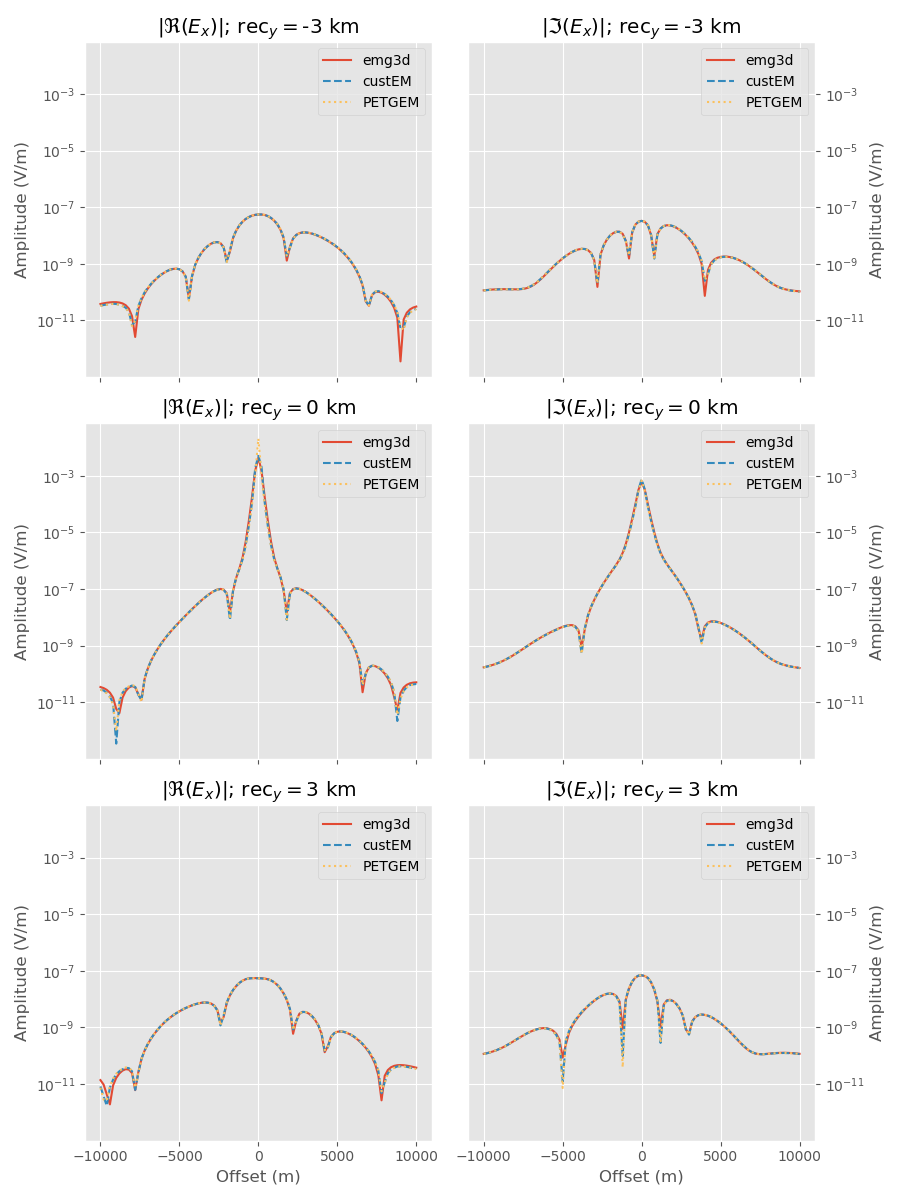

In [12]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(9, 12))

for i, fct in enumerate([np.real, np.imag]):
    for ii, y in enumerate([-3, 0, 3]):
        plt.sca(axs[ii, i])
        
        title = f"$|\Re(E_x)|$" if i == 0 else f"$|\Im(E_x)|$" 
        plt.title(f"{title}; rec$_y=${y} km")
        plt.plot(rec_x, abs(fct(egd_tg[:, ii])), f'C0-', label=f'emg3d')
        plt.plot(rec_x, abs(fct(cst[:, ii])), f'C1--', label=f'custEM')
        plt.plot(rec_x, abs(fct(ptg[:, ii])), f'C4:', label=f'PETGEM')
        plt.yscale('log')
        plt.legend()
        
        plt.ylabel('Amplitude (V/m)')
        if i == 1:
            axs[ii, i].yaxis.set_ticks_position('right')
            axs[ii, i].yaxis.set_label_position('right')
        if ii == 2:
            plt.xlabel('Offset (m)')

plt.yscale('log')
plt.tight_layout()
plt.show()